In [1]:
# Standard libraries
import math
import os
import urllib.request
from functools import partial
from urllib.error import HTTPError
from tqdm.notebook import tqdm
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data


%matplotlib inline

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "data/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/"

# Set seed to ensure that all operations are deterministic for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [2]:
data = pd.read_csv("peanut_data_AllStress20231214.csv")
data

,Gene,as_ctrl_1,as_ctrl_2,as_3dpi_1,as_3dpi_2,as_6dpi_1,as_6dpi_2,as_9dpi_1,as_9dpi_2,ad_ctrl_1,...,as_ctrl_diss,as_diss,ad_ctrl_dro_1,ad_ctrl_dro_2,ad_ctrl_dro_3,ad_dro_1,ad_dro_2,ad_dro_3,ad_ctrl_diss,ad_diss
0,Aradu.000JC,171,128,79,138,90,96,80,158,1155,...,290,198,197,81,162,63,97,60,285,122
1,Aradu.001N3,53,35,12,33,16,11,20,27,856,...,157,194,1032,398,837,32,56,29,249,324
2,Aradu.002J3,36,27,18,30,32,19,24,22,222,...,61,41,30,24,48,8,23,14,63,47
3,Aradu.003TN,1283,868,818,1093,839,692,554,1186,4406,...,914,657,1231,729,1520,587,894,553,1083,626
4,Aradu.0060C,67,66,145,155,187,161,116,95,381,...,26,30,65,33,91,51,261,83,71,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27552,Aradu.ZZD53,843,502,1193,2287,1587,1605,1308,1490,2710,...,986,2029,250,118,294,149,207,165,734,990
27553,Aradu.ZZJ9G,646,488,328,430,297,305,259,393,1469,...,514,250,405,157,316,53,143,64,450,145
27554,Aradu.ZZJ9P,103,43,90,104,43,84,98,62,2539,...,106,53,2195,905,2192,23,40,21,776,191
27555,Aradu.ZZU4A,63,50,26,50,21,40,21,32,412,...,108,121,232,89,184,34,58,35,177,134


In [3]:
# removing rows where none of the values are > 30
data_filtered = data[data[data.columns[1:]].gt(30).any(axis=1)].reset_index(drop=True)
data_filtered.shape

(22649, 36)

In [4]:
# setting a threshold for variance
var_th = 100
# remove rows with less threshold
final_data = data_filtered[data_filtered[data_filtered.columns[1:]].apply(lambda row: row.var() > var_th, axis=1)].reset_index(drop=True)
final_data.shape

(22020, 36)

In [5]:
#seperating the columns for two plant species: ad and as
data_ad_col = [col for col in final_data.columns if col.startswith('ad')]
data_as_col = [col for col in final_data.columns if col.startswith('as')]

data_ad_fin = final_data[data_ad_col]
data_as_fin = final_data[data_as_col]

data_ad_fin.shape,data_as_fin.shape

((22020, 16), (22020, 19))

In [6]:
# removing 3 columns from data_as for classification purposes
data_as_col = [col for col in data_as_fin if col not in ['as_dronema_1','as_dronema_2','as_dronema_3']]
data_as_fin = data_as_fin[data_as_col]
data_as_fin.shape

(22020, 16)

In [7]:
datas_fin = pd.concat((data_ad_fin,data_as_fin),axis=1)
datas_fin

,ad_ctrl_1,ad_ctrl_2,ad_3dpi_1,ad_3dpi_2,ad_6dpi_1,ad_6dpi_2,ad_9dpi_1,ad_9dpi_2,ad_ctrl_dro_1,ad_ctrl_dro_2,...,as_9dpi_1,as_9dpi_2,as_ctrl_dro_dronema_1,as_ctrl_dro_dronema_2,as_ctrl_dro_dronema_3,as_dro_1,as_dro_2,as_dro_3,as_ctrl_diss,as_diss
0,1155,955,1311,1397,1166,1123,862,848,197,81,...,80,158,271,195,224,191,165,142,290,198
1,856,688,785,716,731,838,800,692,1032,398,...,20,27,286,151,220,129,109,95,157,194
2,222,219,231,248,217,226,199,182,30,24,...,24,22,74,54,75,55,54,57,61,41
3,4406,4122,6206,6435,5709,5735,4012,4445,1231,729,...,554,1186,1470,1152,1481,394,444,395,914,657
4,381,322,141,144,378,285,489,508,65,33,...,116,95,62,50,72,7,15,11,26,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22015,2612,1931,1137,1010,1506,1401,2176,2103,442,179,...,904,1069,608,546,673,463,389,348,288,760
22016,2710,2319,1454,1664,2220,1895,2647,2685,250,118,...,1308,1490,375,324,406,172,143,166,986,2029
22017,1469,1257,1647,1724,1366,1514,1202,1058,405,157,...,259,393,771,597,646,731,656,524,514,250
22018,2539,1941,2078,1829,1736,1695,2157,1636,2195,905,...,98,62,139,88,145,135,181,165,106,53


In [8]:
data_ad_finS = RobustScaler().fit_transform(data_ad_fin)
data_as_finS = RobustScaler().fit_transform(data_as_fin)

data_ad_finS.shape,data_as_finS.shape

((22020, 16), (22020, 16))

In [9]:
data_ad = torch.tensor(data_ad_finS,dtype=torch.float32)
data_as = torch.tensor(data_as_finS,dtype=torch.float32)

In [10]:
data_ad.shape[1]

16

In [11]:
# prepare data to pass to the transformer
reshaped_tensor1 = data_ad.view(data_ad.shape[0], data_ad.shape[1], 1)
reshaped_tensor2 = data_as.view(data_as.shape[0], data_as.shape[1], 1)
reshaped_total = torch.cat((reshaped_tensor1, reshaped_tensor2), dim=1)

In [12]:
reshaped_tensor1.shape, reshaped_tensor2.shape, reshaped_total.shape

(torch.Size([22020, 16, 1]),
 torch.Size([22020, 16, 1]),
 torch.Size([22020, 32, 1]))

In [13]:
hive = pd.read_csv('HIVE_SHAPbin_gene_selection.csv').to_numpy().flatten()
hive,len(hive)

(array(['Aradu.003TN', 'Aradu.0060C', 'Aradu.00BL5', ..., 'Aradu.ZZ3JW',
        'Aradu.ZZD2I', 'Aradu.ZZU4A'], dtype=object),
 5840)

### Building transformer

In [14]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    # Compute attn_logits
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits /= math.sqrt(d_k)
    # Apply mask if not None
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, - 1e14)

    # Pass through softmax
    attention = F.softmax(attn_logits, dim=-1)
    
    # Weight values accordingly
    output_values = torch.matmul(attention, v)
    return output_values, attention

In [15]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim # dimension of concatenated heads
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Create linear layers for both qkv and output
        # TIP: Stack all weight matrices 1...h together for efficiency
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        self.qkv_proj = nn.Linear(input_dim,embed_dim*3)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):

        batch_dim, seq_length, input_dim = x.shape
        # Compute linear projection for qkv and separate heads
        # QKV: [Batch, Head, SeqLen, Dims]
        qkv = self.qkv_proj(x)
        qkv=qkv.reshape(batch_dim, seq_length, self.num_heads, 3*self.head_dim)
        qkv=qkv.permute(0,2,1,3)
        q, k, v = torch.chunk(qkv,3,dim=-1)


        # Apply Dot Product Attention to qkv ()
        attention_values, attention = scaled_dot_product(q,k,v,mask)

        # Concatenate heads to [Batch, SeqLen, Embed Dim]
        attention_values = attention_values.permute(0,2,1,3)
        attention_values = attention_values.reshape(batch_dim,seq_length,self.embed_dim)

        # Output projection
        o = self.o_proj(attention_values)

        if return_attention:
            return o, attention
        else:
            return o

In [16]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Create Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Create Two-layer MLP with droput
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2*input_dim, input_dim),
        )

        # Layers to apply in between the main layers (Layer Norm and Dropout)
        self.norm = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        # Compute Attention part
        attn = self.self_attn(x)
        x = self.norm(x+attn)

        # Compute MLP part
        x = self.norm(x+self.mlp(x))
        return x

In [17]:
class DecoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        super().__init__()

        # Create Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Create Two-layer MLP with dropout
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2*input_dim, input_dim),
        )

        # Layers to apply in between the main layers (Layer Norm and Dropout)
        self.norm = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        
        # Compute MLP part (reverse order)
        x = self.norm(x + self.mlp(x))

        # Compute Attention part (reverse order)
        attn = self.self_attn(x)
        x = self.norm(x+attn)

        return x


In [18]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        attention_val = []
        for layer in self.layers:
            attn_val, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map) 
            attention_val.append(attn_val)
            x = layer(x)
        
        return attention_maps,attention_val

In [19]:
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([DecoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self,x, mask=None):
        for layer in self.layers:
            # Pass encoder output to each decoder block along with decoder input
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        attention_val = []
        for layer in self.layers:
            attn_val, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            attention_val.append(attn_val)
            x = layer(x)
        
        return attention_maps, attention_val


In [20]:
class Fusion_attn(nn.Module):
    def __init__(
        self,
        input_dim1,
        input_dim2,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        attn_type,
        dropout=0.0,
        input_dropout=0.0,
    ):
        """
        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_classes: Number of classes to predict per sequence element
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            warmup: Number of warmup steps. Usually between 50 and 500
            max_iters: Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features
        """
        torch.manual_seed(24)
        np.random.seed(24)
        random.seed(24)
        super().__init__()
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.model_dim = model_dim
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
        self.input_dropout = input_dropout
        self.attn_type = attn_type
        self.criterion = nn.MSELoss()

        # Create a Generic Input Encoder Input dim -> Model dim with input dropout
        self.input_net1 = nn.Sequential(
            nn.Linear(input_dim1, self.model_dim),
            nn.Dropout(input_dropout)
        )
        if self.input_dim2 is not None:
            self.input_net2 = nn.Sequential(
                nn.Linear(input_dim2, self.model_dim),
                nn.Dropout(input_dropout)
            )
            self.output_net2 = nn.Linear(model_dim, self.input_dim2)

        # Create transformer Encoder
        self.encoder = TransformerEncoder(num_layers, input_dim=model_dim, dim_feedforward=model_dim*2, num_heads=num_heads, dropout=dropout)
        # Create transformer Decoder
        self.decoder = TransformerDecoder(num_layers, input_dim=model_dim, num_heads=num_heads, dim_feedforward=model_dim*2, dropout=dropout)
        
        # Create output classifier per sequence element Model_dim -> num_classes
        self.output_net1 = nn.Linear(model_dim, input_dim1)

        # Create transformer Encoder
        self.transformer = TransformerEncoder(num_layers, input_dim=model_dim, dim_feedforward=model_dim*2, num_heads=num_heads, dropout=dropout)

        # Create output classifier per sequence element Model_dim -> num_classes
        self.output_net = nn.Linear(model_dim, num_classes)

    def forward(self, x1,x2, mask=None):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
            add_positional_encoding: If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x1 = self.input_net1(x1)
        x1 = self.transformer(x1, mask=mask)
        x1 = self.output_net(x1)
        
        if x2 is not None:
            x2 = self.input_net2(x2)
            x2 = self.transformer(x2, mask=mask)
            x2 = self.output_net(x2)
        
        if self.attn_type == 'early_fusion':
            fused_output = x1
        elif self.attn_type == 'late_fusion':
            # Elemenet-wise average
            fused_output = 0.5 * (x1 + x2)
        elif self.attn_type == 'hierarchical_fusion':
            fused_rep = 0.5 * (x1 + x2)
            fused_net = nn.Sequential(
            nn.Linear(self.num_classes, self.model_dim),
            nn.Dropout(self.input_dropout)
        )
            x_comb = fused_net(fused_rep)
            x_comb = self.transformer(x_comb)
            fused_output = self.output_net(x_comb)
        else:
            raise ValueError("Possible attention types are early_fusion, late_fusion or hierarchical_fusion ")
        
        log_probabilities = F.log_softmax(fused_output, dim=-1)
        probabilities = torch.exp(log_probabilities)
        return probabilities
    
    def reconstruction(self,x1,x2,mask=None):
        
        x1_encoded = self.input_net1(x1)
        x1_encoded = self.encoder(x1_encoded, mask=mask)
        x1_decoded = self.decoder(x1_encoded, mask=mask)
        x1_reconstructed = self.output_net1(x1_decoded)
        
        if x2 is not None:
            x2_encoded = self.input_net2(x2)
            x2_encoded = self.encoder(x2_encoded, mask=mask)
            x2_decoded = self.decoder(x2_encoded, mask=mask)
            x2_reconstructed = self.output_net2(x2_decoded)
        
        if self.attn_type == 'early_fusion':
            output1 = x1_reconstructed
            output2 = None
            loss = self.criterion(output1, x1)

            # Convert PyTorch tensors to NumPy arrays for variance calculation
            output1_np = output1.detach().cpu().numpy()
            x1_np = x1.detach().cpu().numpy()

            # Calculate the variance of the true values
            var_true = np.var(x1_np)

            # Calculate the Normalized Mean Squared Error (NMSE)
            nmse = loss.item() / var_true
            return (1 - (nmse / (1 + nmse)))
        elif self.attn_type == 'late_fusion':
            # Elemenet-wise average
            output1 = x1_reconstructed
            output2 = x2_reconstructed
            loss1 = self.criterion(output1, x1)
            loss2 = self.criterion(output2, x2)

            # Convert PyTorch tensors to NumPy arrays for variance calculation
            output1_np = output1.detach().cpu().numpy()
            x1_np = x1.detach().cpu().numpy()
            output2_np = output2.detach().cpu().numpy()
            x2_np = x2.detach().cpu().numpy()

            # Calculate the variance of the true values
            var_true1 = np.var(x1_np)
            var_true2 = np.var(x2_np)

            # Calculate the Normalized Mean Squared Error (NMSE)
            nmse1 = loss1.item() / var_true1
            nmse2 = loss2.item() / var_true2
            return [1 - (nmse1 / (1 + nmse1)),1 - (nmse2 / (1 + nmse2))]
        elif self.attn_type == 'hierarchical_fusion':
            x1_1 = self.output_net(x1_encoded)
            x2_1 = self.output_net(x2_encoded)
            fused_rep = 0.5 * (x1_1 + x2_1)
            fused_net = nn.Sequential(
            nn.Linear(self.num_classes, self.model_dim),
            nn.Dropout(self.input_dropout)
        )
            x_comb = fused_net(fused_rep)
            x_comb = self.encoder(x_comb)
            x_comb = self.decoder(x_comb)
            output1 = self.output_net(x_comb)
            output2 = fused_rep
            criterion = nn.MSELoss()
            loss = self.criterion(output1, output2)

            # Convert PyTorch tensors to NumPy arrays for variance calculation
            output1_np = output1.detach().cpu().numpy()
            output2_np = output2.detach().cpu().numpy()

            # Calculate the variance of the true values
            var_true = np.var(output1_np)

            # Calculate the Normalized Mean Squared Error (NMSE)
            nmse = loss.item() / var_true
            return 1 - (nmse / (1 + nmse))
        else:
            raise ValueError("Possible attention types are early_fusion, late_fusion or hierarchical_fusion ")
        

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None):
        """Function for extracting the attention matrices of the whole Transformer for a single batch.

        Input arguments same as the forward pass.
        """
        input_net = nn.Sequential(
            nn.Linear(x.shape[2], self.model_dim),
            nn.Dropout(self.input_dropout)
        )
        x = input_net(x)
        attention_maps, attention_val = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps, attention_val

In [21]:
def call_model(data1,data2,attn_type,num_classes,model_dim,num_heads,num_layers):
    if data2!=None:
        input_dim1 = data1.shape[2]
        input_dim2 = data2.shape[2]
    else:
        input_dim1 = data1.shape[2]
        input_dim2 = None
    model = Fusion_attn(input_dim1=input_dim1,input_dim2=input_dim2,attn_type=attn_type, 
                                   num_classes=num_classes,model_dim=model_dim, num_heads=num_heads, num_layers=3)
    fused_output = model(data1,data2)
    # mean of probs along feature and then obtaining label based on max prob avg
    predicted_classes = torch.argmax(fused_output.mean(dim=1),dim=-1)
    print("class distribution:\n",pd.DataFrame(predicted_classes).value_counts())
    final_labels = pd.DataFrame({'GeneName':final_data['Gene'].values,'Labels':predicted_classes})
    # check in hive
    final_labels['hive'] = final_labels['GeneName'].apply(lambda x: 1 if x in hive else 0)
#     print("Percentage of labels matching with ")
    minC = final_labels['Labels'].value_counts().idxmin()
    filtered_df = final_labels[(final_labels['Labels'] == minC) & (final_labels['hive'] == 1)]
    percentage = (len(filtered_df) / len(final_labels[final_labels['hive'] == 1])) * 100
    filtered_df_c = final_labels[(final_labels['Labels'] != minC) & (final_labels['hive'] == 0)]
    percentage_c = (len(filtered_df_c) / len(final_labels[final_labels['hive'] == 0])) * 100
    print("Percentage of genes whose labels match with hive biotic/abiotic labels : ",percentage)
    print("Percentage of genes whose labels match with hive ctrl labels : ",percentage_c)
    attention_maps, attention_val = model.get_attention_maps(data1)
    
    rec_error = model.reconstruction(data1,data2)
    print("Reconstruction error: ",rec_error)
    return final_labels, attention_maps, attention_val

In the below code snippet, in line 6, only pass data1 and data2 will be None for early fusion. For data 1, either individual data for A.S.(reshaped_tensor1) and A.D.(reshaped_tensor2) can be passed or concatenation of both (reshaped_total) can be passed. To work with late fusion or hierarchical fusion, uncomment line7 and comment line 6, and change attn parameter accordingly either as late_Fusion or hierarchical_fusion.

In [22]:
array_trial = [[8,2,3],[10,2,1],[8,2,1],[8,4,1],[5,1,1]]
list_res =[]

for l in array_trial:
    print(l[0],l[1],l[2])
    final_labels, attention_maps, attention_val = call_model(data1=reshaped_total,data2=None,attn_type='early_fusion',num_classes=2,model_dim=l[0],num_heads=l[1],num_layers=l[2])
#     final_labels, attention_maps, attention_val = call_model(data1=reshaped_tensor1,data2=reshaped_tensor2,attn_type='late_fusion',num_classes=2,model_dim=l[0],num_heads=l[1],num_layers=l[2])
    minC = final_labels['Labels'].value_counts().idxmin()
    print("variance_c | variance_AB")
    variance_c = np.var(datas_fin.loc[final_labels.loc[final_labels['Labels'] != minC].index].values)
    variance_AB = np.var(datas_fin.loc[final_labels.loc[final_labels['Labels'] == minC].index].values)
    if math.isnan(variance_c) or math.isnan(variance_AB):
        print("Single cluster returned")
    else:
        print(variance_c,"   |   ",variance_AB)
        print("variance_AB is ",variance_AB/variance_c," times greater than variance_c")
        print("Silhouette score : ",silhouette_score(datas_fin, final_labels['Labels'].values),"\n")

8 2 3
class distribution:
 1    20960
0     1060
dtype: int64
Percentage of genes whose labels match with hive biotic/abiotic labels :  1.8949648077964267
Percentage of genes whose labels match with hive ctrl labels :  94.20474543358213
Reconstruction error:  0.4996494230779873
variance_c | variance_AB
40764019.13372796    |    728343.3426735353
variance_AB is  0.017867309410393918  times greater than variance_c
Silhouette score :  0.02206019236252721 

10 2 1
class distribution:
 1    21193
0      827
dtype: int64
Percentage of genes whose labels match with hive biotic/abiotic labels :  3.086085544125609
Percentage of genes whose labels match with hive ctrl labels :  96.01917592086899
Reconstruction error:  0.4990417595179302
variance_c | variance_AB
31921715.543373454    |    189404598.2081454
variance_AB is  5.933409122413642  times greater than variance_c
Silhouette score :  0.8523540222445736 

8 2 1
class distribution:
 1    20960
0     1060
dtype: int64
Percentage of genes whose

In [23]:
## select best parameters, and run model again
final_labels, attention_maps, attention_val = call_model(data1=reshaped_total,data2=None,attn_type='early_fusion',num_classes=2,model_dim=10,num_heads=2,num_layers=1)
#     final_labels, attention_maps, attention_val = call_model(data1=reshaped_tensor1,data2=reshaped_tensor2,attn_type='late_fusion',num_classes=2,model_dim=l[0],num_heads=l[1],num_layers=l[2])
minC = final_labels['Labels'].value_counts().idxmin()

class distribution:
 1    21193
0      827
dtype: int64
Percentage of genes whose labels match with hive biotic/abiotic labels :  3.086085544125609
Percentage of genes whose labels match with hive ctrl labels :  96.01917592086899
Reconstruction error:  0.4990417595179302


In [24]:
# final_labels.to_csv('outputs/AS.csv')

In [25]:
# just to check variability in attention values to display attention matrix
def identify_samples_with_high_variance(attn_maps, threshold):
    # Calculate the standard deviation of attention values for each sample
    attn_maps_array = np.array([tensor.numpy() for tensor in attn_maps])

    # Calculate the standard deviation of attention values for each sample
    attn_std_dev = np.std(attn_maps_array, axis=(2, 3, 4))  # Calculate std dev across heads and spatial dimensions

    # Find samples where the standard deviation exceeds the threshold
    high_variance_samples = np.where(attn_std_dev > threshold)[1]

    return high_variance_samples

threshold = 0.15  # Example threshold value
high_variance_samples = identify_samples_with_high_variance(attention_maps, threshold)
print("Samples with high variance in attention:", high_variance_samples)

Samples with high variance in attention: [   75   197   232   245   393   442  1065  1652  1857  1937  2291  2951
  3761  3834  3930  4927  5157  5546  5619  5915  6113  6311  6535  7118
  7256  8457  8616  8694  8867  8964  9540  9852  9997 10208 10318 11165
 11358 11613 11652 11817 11862 11915 12124 12137 12139 12363 13121 13283
 13964 14426 14505 15176 15259 15294 15830 15886 16224 16870 17200 17336
 17362 17431 18015 18088 18576 19333 20363 21145 21667 21996]


In [26]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads * fig_size, num_layers * fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            im = ax[row][column].imshow(attn_maps[row][column], origin="lower", vmin=0)
            cbar = fig.colorbar(im, ax=ax[row][column])
            cbar.set_label('Attention Weight')
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(datas_fin.columns,rotation=90)
#             ax[row][column].set_xticklabels(final_data[data_ad_col].columns,rotation=90)
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(datas_fin.columns)
#             ax[row][column].set_yticklabels(final_data[data_ad_col].columns)
            ax[row][column].set_title("Layer %i, Head %i" % (row + 1, column + 1))
    fig.subplots_adjust(hspace=0.5)
    plt.show()

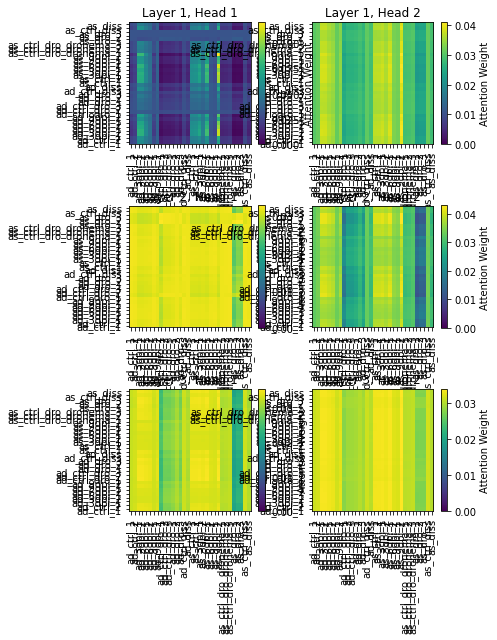

In [27]:
plot_attention_maps(reshaped_total, attention_maps, idx=3)  # idx : 0 to 22019, with respect to features

In [30]:
AS = pd.read_csv("outputs/AS.csv",index_col=0)
AD = pd.read_csv("outputs/AD.csv",index_col=0)
early = pd.read_csv("outputs/Early.csv",index_col=0)

In [31]:
early_equals = early[((AS['Labels']==AD['Labels']))]

In [32]:
early_equals['Labels'].value_counts()

1    21085
0      466
Name: Labels, dtype: int64